<a href="https://colab.research.google.com/github/StanleyLiangYork/2023_journal_club_CNN4N/blob/main/inception_net_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
import numpy as np
import os
from matplotlib import pyplot as plt

print(tensorflow.__version__)

2.12.0


(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


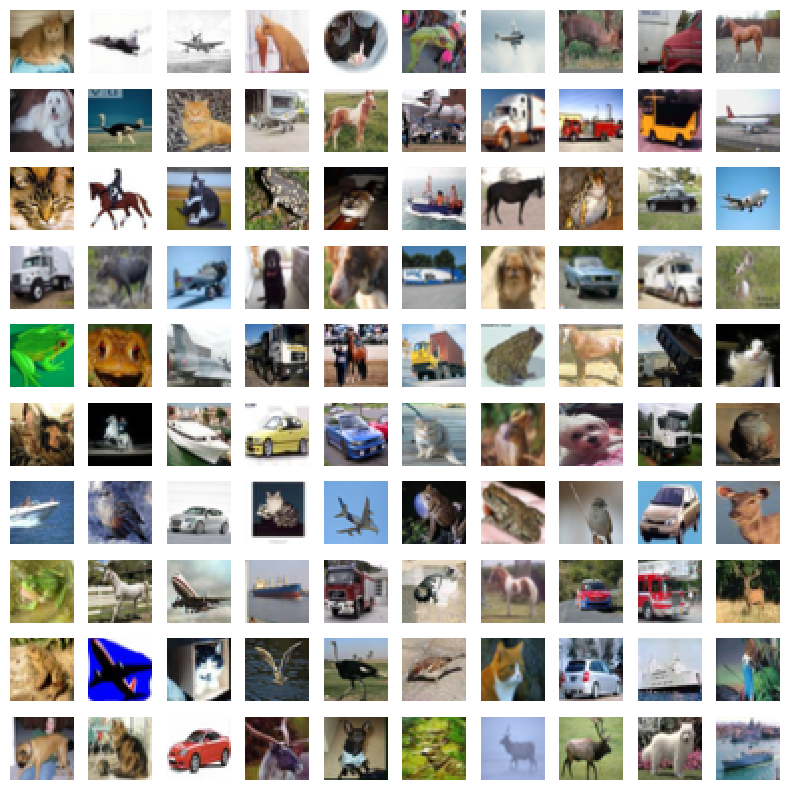

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

ROWS = 10
x = x_train.astype('uint8')
fig, axes1 = plt.subplots(ROWS,ROWS,figsize=(8,8))

for i in range(ROWS):
  for j in range(ROWS):
    idx = np.random.choice(range(len(x)))
    axes1[i][j].axis('off')
    axes1[i][j].imshow(x[idx:idx+1][0])

plt.tight_layout()
plt.show()


In [ ]:
nRows,nCols,nDims = x_train.shape[1:]
input_shape = (nRows, nCols, nDims)
classes = np.unique(y_train)
nClasses = len(classes)

In [ ]:
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)
y_train = tf.squeeze(y_train, axis=-1)
y_test = tf.squeeze(y_test, axis=-1)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


In [ ]:
# load the data to the dataset iterator objects
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [ ]:
# define the image rescale and augmentation layers inside the model
# it will improve runtime performance

img_augmentation = Sequential([
    tf.keras.layers.Rescaling(scale=1./255.),
    tf.keras.layers.RandomRotation(factor=0.15),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [ ]:
def define_inception_net():
  
  inputs = Input(shape=(32,32,3))

  x = img_augmentation(inputs)

  # the first inception block
  # first inception layer
  x1 = Conv2D(30, (1,1), padding='same', activation='relu')(x)
  x1 = Conv2D(30, (3,3), padding='same', activation='relu')(x1)
  x1 = Dropout(0.3)(x1)
  #x1 = BatchNormalization()(x1)

  x2 = Conv2D(30, (1,1), padding='same', activation='relu')(x)
  x2 = Conv2D(30, (5,5), padding='same', activation='relu')(x2)
  x2 = Dropout(0.3)(x2)
  #x2 = BatchNormalization()(x2)
  
  x3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
  x3 = Conv2D(30, (1,1), padding='same', activation='relu')(x3)
  x3 = Dropout(0.3)(x3)
  #x3 = BatchNormalization()(x3)
  
  # the concatenate method is important for many complex NN architecture
  merge_1 = tf.keras.layers.concatenate([x1, x2, x3], axis = 3)
  merge_1 = BatchNormalization()(merge_1)
  merge_1 = Dropout(0.3)(merge_1)

  x = Flatten()(merge_1)
  x = Dense(1000, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.3)(x)
  x = Dense(500, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.3)(x)
  x = Dense(250, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.3)(x)

  y = Dense(nClasses)(x)
  model = Model(inputs=[inputs], outputs=y)
  return model


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 img_augmentation (Sequential)  (None, 32, 32, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 32, 32, 30)   120         ['img_augmentation[1][0]']       
                                                                                                  
 conv2d_7 (Conv2D)              (None, 32, 32, 30)   120         ['img_augmentation[1][0]']       
                                                                                            

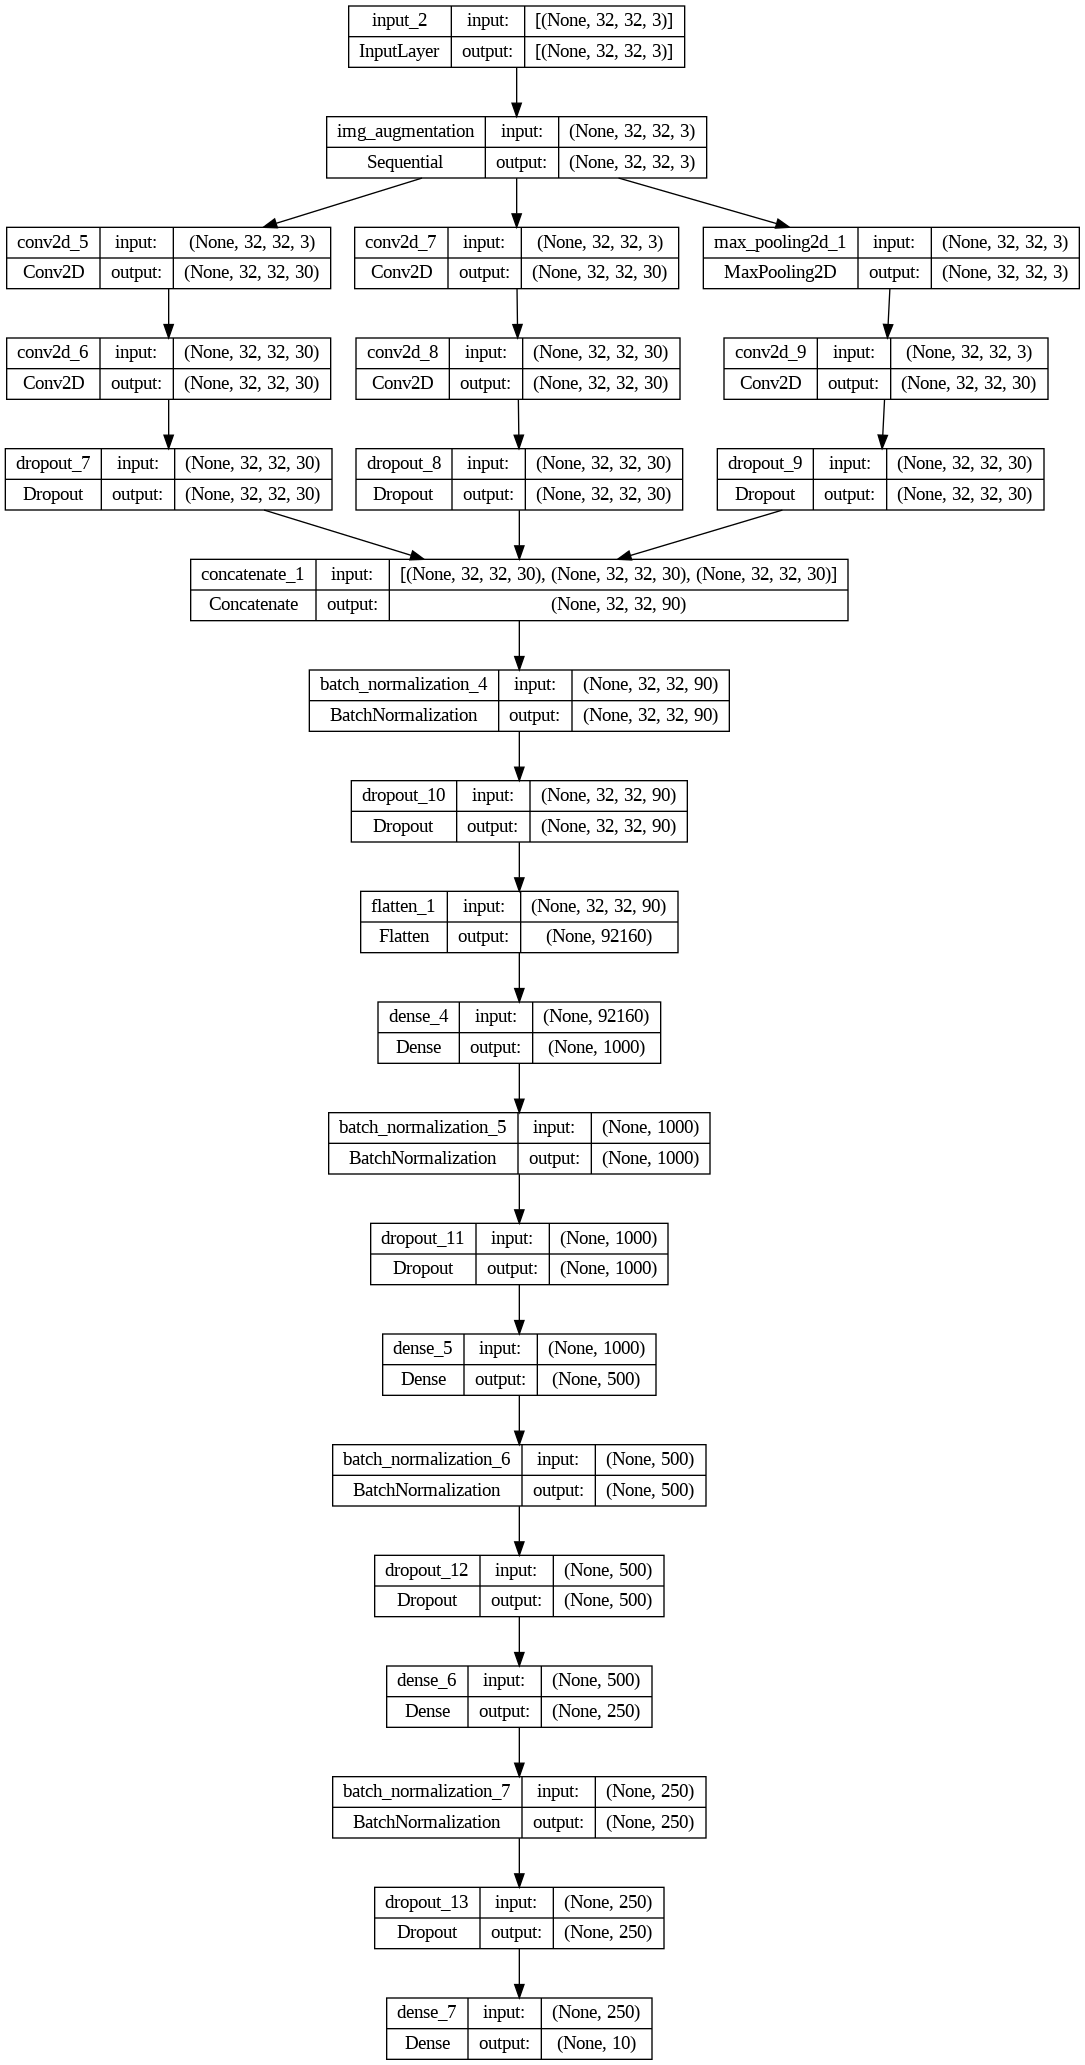

In [ ]:
model = define_inception_net()
model.summary()
plot_model(model, to_file='inceptionNet.png', show_shapes=True, show_layer_names=True)

In [ ]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss=criterion, optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

In [ ]:
history = model.fit(x=train_ds, validation_data=test_ds, epochs=30, verbose=2)

Epoch 1/30
1563/1563 - 24s - loss: 2.2572 - accuracy: 0.2680 - val_loss: 1.7367 - val_accuracy: 0.3960 - 24s/epoch - 16ms/step
Epoch 2/30
1563/1563 - 19s - loss: 1.9236 - accuracy: 0.3332 - val_loss: 1.5317 - val_accuracy: 0.4532 - 19s/epoch - 12ms/step
Epoch 3/30
1563/1563 - 19s - loss: 1.7929 - accuracy: 0.3620 - val_loss: 1.5474 - val_accuracy: 0.4415 - 19s/epoch - 12ms/step
Epoch 4/30
1563/1563 - 19s - loss: 1.7057 - accuracy: 0.3910 - val_loss: 1.5680 - val_accuracy: 0.4611 - 19s/epoch - 12ms/step
Epoch 5/30
1563/1563 - 19s - loss: 1.6545 - accuracy: 0.4053 - val_loss: 1.4008 - val_accuracy: 0.4909 - 19s/epoch - 12ms/step
Epoch 6/30
1563/1563 - 19s - loss: 1.6081 - accuracy: 0.4202 - val_loss: 1.5473 - val_accuracy: 0.4645 - 19s/epoch - 12ms/step
Epoch 7/30
1563/1563 - 19s - loss: 1.5707 - accuracy: 0.4344 - val_loss: 1.3918 - val_accuracy: 0.4968 - 19s/epoch - 12ms/step
Epoch 8/30
1563/1563 - 19s - loss: 1.5404 - accuracy: 0.4447 - val_loss: 1.3255 - val_accuracy: 0.5181 - 19s/ep

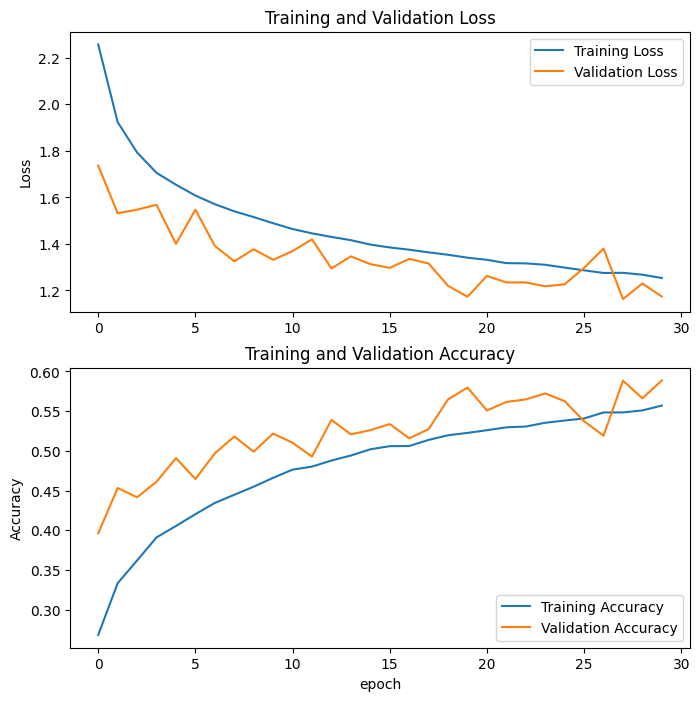

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.subplot(2, 1, 2)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.show()